In [5]:
import math
import os
from os import listdir, mkdir
from os.path import isfile, join
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import seaborn as sns
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [6]:
def getCsiMatrFromCsv(fileName: str, CsiFilesFolder: str) -> pd.DataFrame:
    csvFilePath = join(CsiFilesFolder, fileName)
    return pd.read_csv(csvFilePath)


def getCsiDictFromDataset(dataset_folder: str = "dataset") -> {str: pd.DataFrame}:
    csi_dict: {str: pd.DataFrame} = dict()
    csiFiles = [fileName for fileName in listdir(dataset_folder) if isfile(join(dataset_folder, fileName))]
    for idx, fileName in enumerate(csiFiles):
        csi_matrix = getCsiMatrFromCsv(fileName, dataset_folder)
        # csi_matrix.head(2)
        csi_dict[fileName] = csi_matrix
    return csi_dict


def upload2Dataset(csi_dict: {str: pd.DataFrame}, csi_cvs_folder: str = "dataset", csvFileName: str = ""):
    # fileName == "fileName.csv"
    csi_cvs_folder = csi_cvs_folder
    if isinstance(csi_dict, pd.DataFrame):
        csi_dict.to_csv(join(csi_cvs_folder, csvFileName), index=False)
        return

    for fileName in csi_dict:
        csvFileName = fileName[:-3] + "csv"
        csi_dict[fileName].to_csv(join(csi_cvs_folder, csvFileName), index=False)

## Download csi_dict

In [7]:
dataset_folder = "dataset1"
csi_dict = getCsiDictFromDataset(dataset_folder)

## PCA preparation

### change all NaN and +-inf values in file to median of corresponding packet or delete the packet if those values too much

In [8]:
for fileName in csi_dict:
    csi_matrix = csi_dict[fileName]
    # print(csi_matrix)
    csi_matrix.replace(np.inf, np.nan, inplace=True)
    csi_matrix.replace(-np.inf, np.nan, inplace=True)
    for idx in range(len(csi_matrix.index.values)):
        packet = csi_matrix.iloc[idx]
        stateMass = ((packet == np.nan) | (packet == np.inf) | (packet == -np.inf))
        stateMassSum = stateMass.sum()

        if 0 < stateMassSum < (0.3 * len(packet)):
            csi_matrix.iloc[idx].replace(np.nan, packet.mean(), inplace=True)

    csi_matrix.replace(np.nan, csi_matrix.mean(), inplace=True)
    csi_dict[fileName] = csi_matrix



##### check if  NaN, +-inf present in files

In [9]:
for fileName in csi_dict:
    csi_matrix = csi_dict[fileName]
    for idx in csi_matrix.index.values:
        packet = csi_matrix.iloc[idx]
        if any((packet == np.nan) | (packet == np.inf) | (packet == -np.inf)):
            print(fileName, idx)

### data standardization


In [10]:
for fileName in csi_dict:
    csi_matrix = csi_dict[fileName]
    csi_dict[fileName] = pd.DataFrame(StandardScaler().fit_transform(csi_matrix))


### splitting dataset to train and test part and creating one DataFrame with all data from train dataset part

In [11]:
actions_dict: {str: [str, ]} = dict()
for fileName in csi_dict:
    actionName = re.sub(r"_\d{1,10}.csv", "", fileName)
    if actions_dict.get(actionName, -1) == -1:
        actions_dict[actionName] = []
    actions_dict[actionName].append(fileName)

train_filesName = []
test_filesName = []

train_size = 0.75

In [12]:
for actionName in actions_dict:
    files_list = actions_dict[actionName]
    splitIdx = int(len(files_list) * train_size)
    train_filesName.extend(files_list[:splitIdx])
    test_filesName.extend(files_list[splitIdx:])

In [13]:
train_dataset_path = f"{dataset_folder}/train_part"
test_dataset_path = f"{dataset_folder}/test_part"

if not os.path.exists(train_dataset_path):
    mkdir(train_dataset_path)

if not os.path.exists(test_dataset_path):
    mkdir(test_dataset_path)

trainDf = pd.DataFrame()

for fileName in csi_dict:
    csi_matrix = csi_dict[fileName]
    if fileName in train_filesName:
        upload2Dataset(csi_matrix, csi_cvs_folder=train_dataset_path, csvFileName=fileName)
        trainDf = pd.concat([trainDf, csi_matrix])

    elif fileName in test_filesName:
        upload2Dataset(csi_matrix, csi_cvs_folder=test_dataset_path, csvFileName=fileName)

trainDf

0         1         2         3         4         5         6    \
0   -0.064365  0.703099  0.342332 -0.401249  0.940507  0.976272  1.004206   
1    0.908846  0.989389  0.342332 -0.827069 -0.810494 -0.735811 -1.015636   
2   -0.293969  0.962800  0.905771 -0.259636  1.001982  1.004144  1.002124   
3    0.858975 -0.581920  1.194505 -0.614159 -1.282473 -1.004000 -1.461981   
4   -2.489279 -0.818479 -1.397263  0.297531  0.966000  0.987640  1.007781   
..        ...       ...       ...       ...       ...       ...       ...   
345  0.232842 -1.469347  0.708785  0.527707  0.250350  0.266832  0.277587   
346 -1.060203 -0.314935 -1.123181  0.471331  0.227485  0.245791  0.277265   
347  1.472750  1.308130  0.970606 -0.101304  0.292586  0.256377  0.283371   
348  1.093768  0.755108 -0.234822 -0.320421  0.331626  0.327698  0.299101   
349  0.053565  0.387451  1.021273 -0.101304  0.375367  0.323690  0.294244   

          7         8         9    ...       232       233       234  \
0    1.008862  1.000337  0.996487  ...  0.844445  0.960233  0.941146   
1   -1.000151 -1.598679 -1.199687  ... -1.009485 -1.137951 -1.181360   
2    1.007898  0.997194  0.992328  ...  0.965253  0.886663  0.902339   
3   -1.000151 -1.330900 -1.760344  ... -1.112119  0.126172  0.171836   
4    1.012236  0.998493  0.996204  ...  0.816868  0.959341  0.945523   
..        ...       ...       ...  ...       ...       ...       ...   
345  0.273258  0.274452  0.272614  ...  0.447076  0.471333  0.363875   
346  0.266006  0.273701  0.263645  ...  0.408445  0.500186  0.394807   
347  0.274237  0.292070  0.269805  ...  0.313938  0.410800  0.380817   
348  0.299527  0.297229  0.289559  ...  0.378731  0.273072  0.280592   
349  0.284206  0.284101  0.284444  ...  0.450199  0.267519  0.301695   

          235       236       237       238       239       240       241  
0    0.964667  0.955979  0.933509  0.283708 -1.117286 -0.829408 -0.995287  
1   -1.480045 -1.661431 -1.443087 -1.170695 -0.835023  0.483966  0.212013  
2    0.930598  0.952918  0.934222 -0.600831 -0.344413 -1.107112  0.717263  
3    0.154505 -0.515548  0.294367  3.395751  3.392937  0.879877 -0.541259  
4    0.957979  0.962820  0.939704  0.177311 -0.156149  0.909497 -0.593132  
..        ...       ...       ...       ...       ...       ...       ...  
345  0.323164  0.292007  0.289318  0.657870  0.300551 -1.111198  0.147736  
346  0.339492  0.304330  0.291178  0.488828 -2.027403 -0.150434 -3.094053  
347  0.338217  0.299807  0.290054  0.520084 -0.338413  0.449447  0.860382  
348  0.260305  0.295912  0.293221 -0.316328  0.737841 -0.361043  1.060378  
349  0.282890  0.304269  0.296369 -0.076511  0.290183 -0.003457  0.676405  

[72011 rows x 242 columns]

## PCA transformation

In [14]:
pca = PCA(n_components=3)
pca.fit(trainDf)
pca.explained_variance_ratio_

array([0.71343859, 0.07818252, 0.01728704])

### uploading pca transformed data, creating dict of files components

In [15]:
# fileName == 'actionType_number.csv'
components_dict: {str: pd.DataFrame} = dict()
for fileName in train_filesName:
    components_dict[fileName] = pd.DataFrame(pca.transform(csi_dict[fileName]))
    upload2Dataset(components_dict[fileName], csi_cvs_folder=train_dataset_path, csvFileName=fileName)

for fileName in test_filesName:
    upload2Dataset(pd.DataFrame(pca.transform(csi_dict[fileName])), csi_cvs_folder=test_dataset_path, csvFileName=fileName)

fileName = list(components_dict.keys())[0]
compon_matrix = components_dict[fileName]
compon_matrix.plot.line(subplots=True)
plt.title(fileName[:-4], y=5)

### Components plot

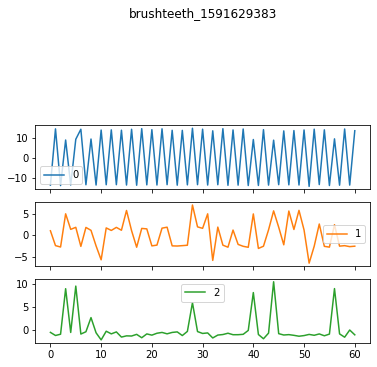

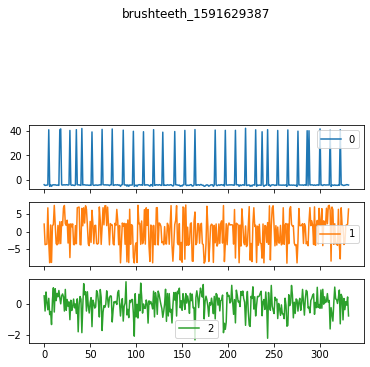

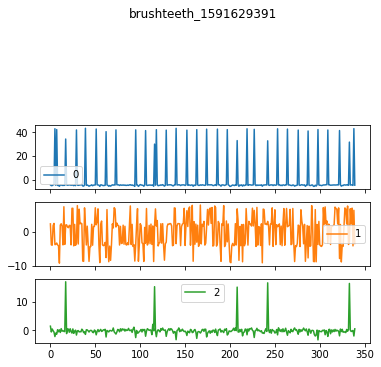

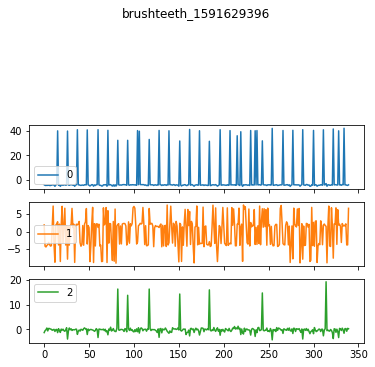

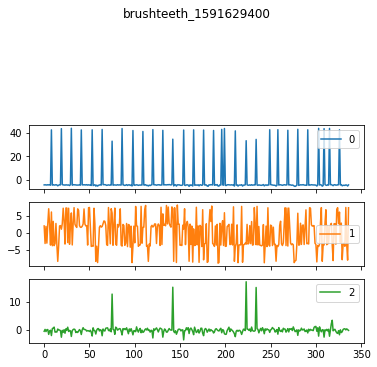

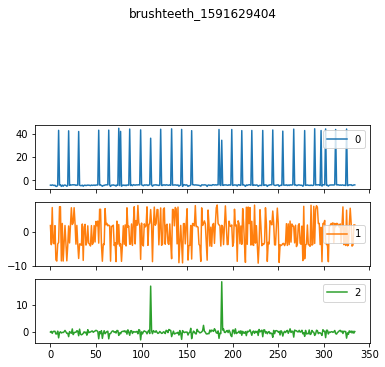

In [16]:
for idx, fileName in enumerate(components_dict):
    components_dict[fileName].plot.line(subplots=True)
    plt.title(fileName[:-4], y=5)
    # plt.savefig(f"pictures/{dataset_folder}/files_components_plot/dataset_components_plot_{fileName[:-4]}.jpg",
    #             bbox_inches="tight")
    if idx < 5:
        plt.show()
    else:
        # break
        # plt.clf()
        plt.close()

### CWT

https://www.l3harrisgeospatial.com/docs/wv_cwt.html

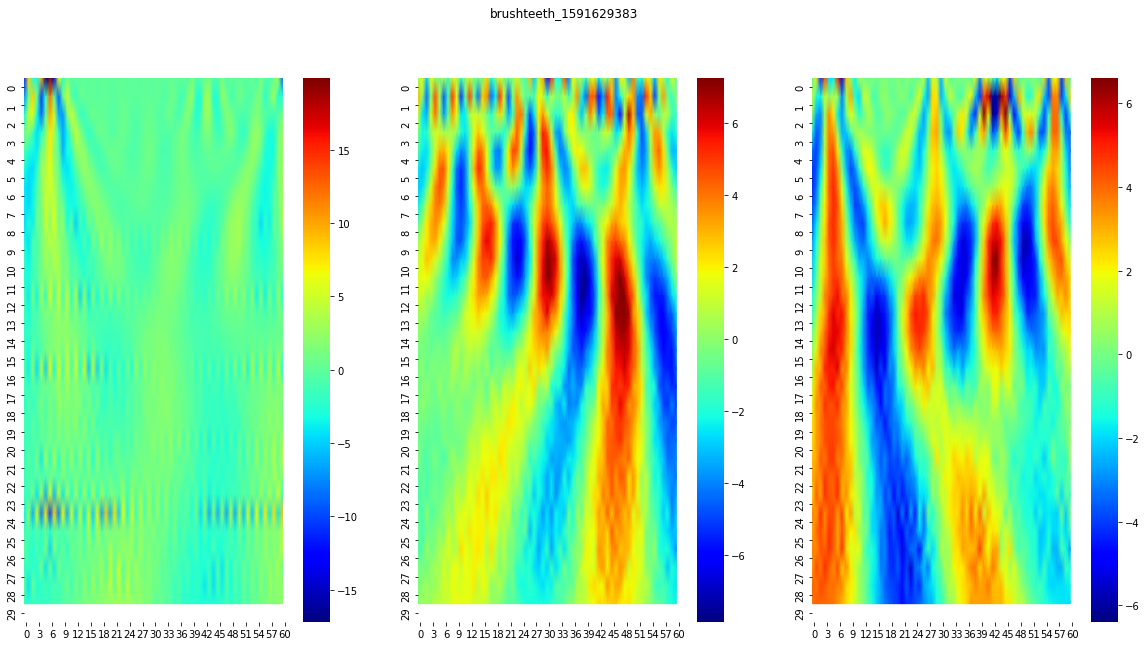

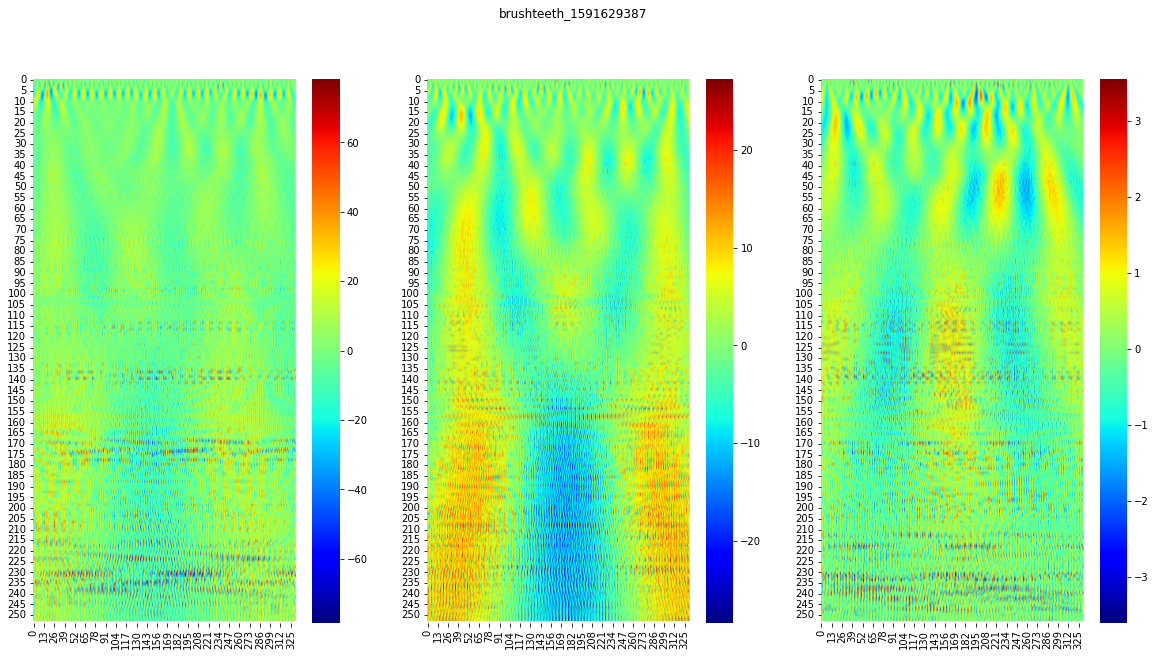

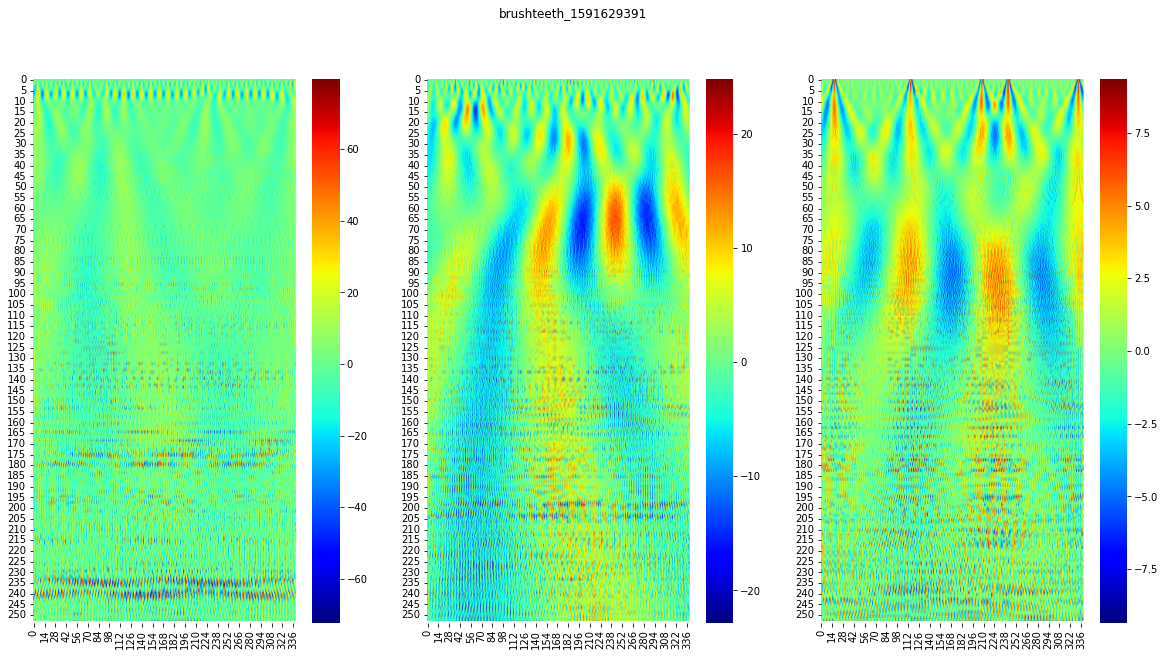

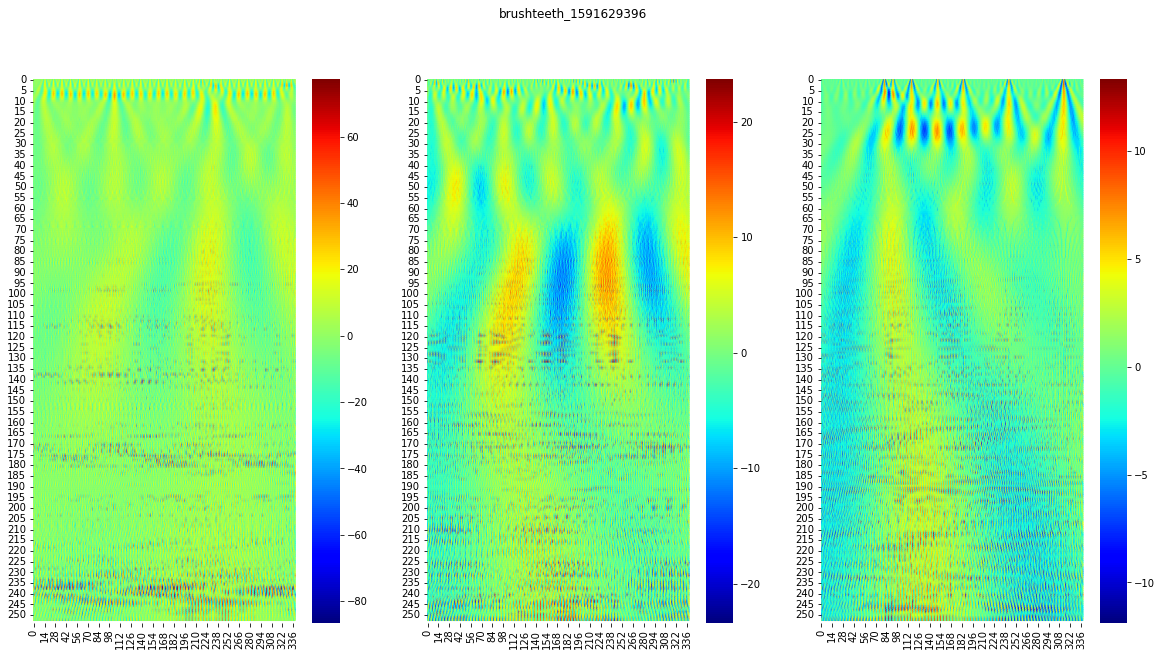

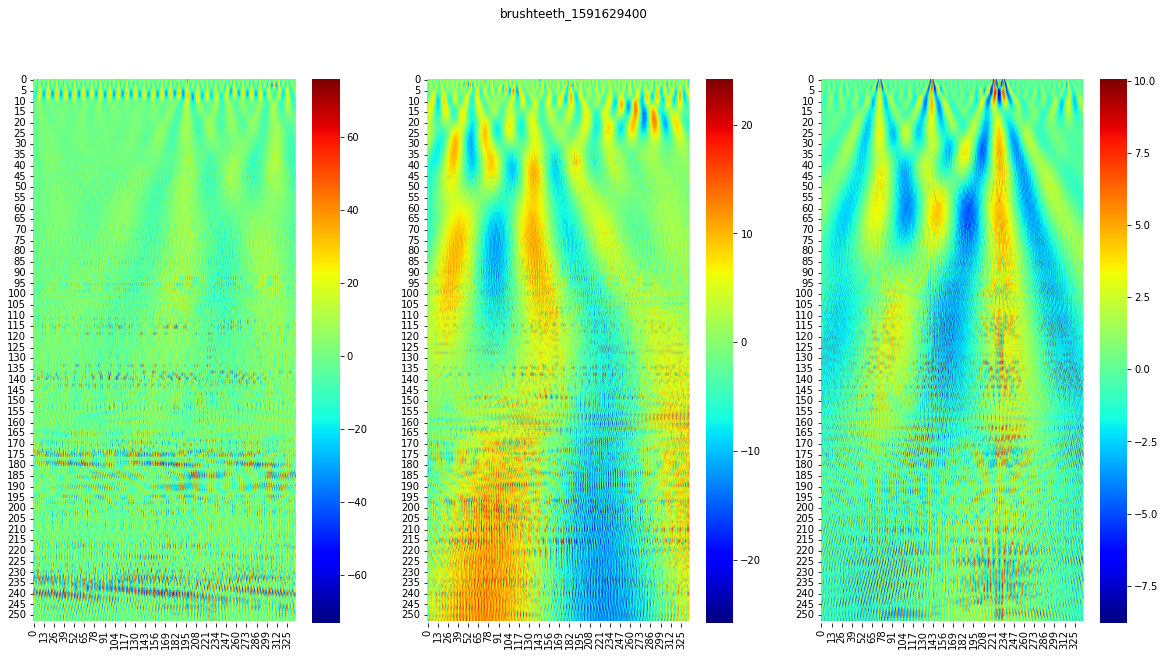

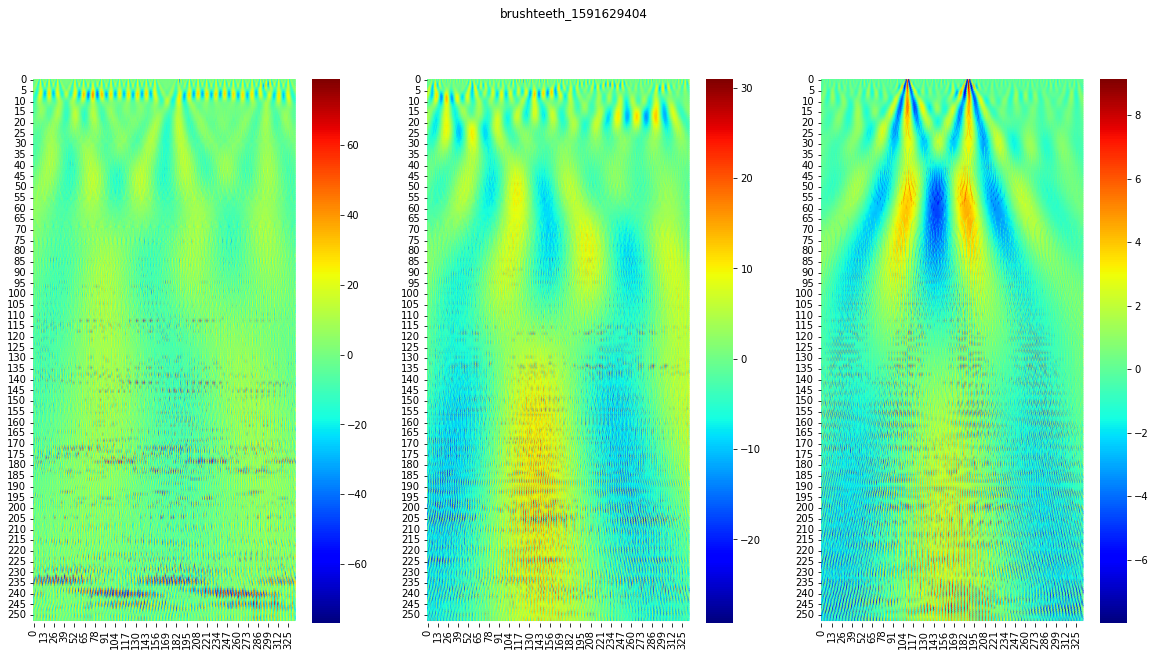

In [17]:
for eIdx, fileName in enumerate(components_dict):
    compon_matrix = components_dict[fileName]
    # rowsN = (compon_matrix.shape[1] // 3) + 1 \
    #     if (compon_matrix.shape[1] % 3) != 0 else (compon_matrix.shape[1] // 3)
    rowsN = 1
    colsN = compon_matrix.shape[1]
    fig, axes = plt.subplots(rowsN, colsN, figsize=(20, 10))
    fig.suptitle(fileName[:-4])
    # colI = 0
    # rowI = 0
    for idx in compon_matrix.columns:
        scales: list

        N = len(compon_matrix[idx])
        start_scale = 2
        dscale = 0.25
        nscale = (int(math.log2(N / start_scale)) / dscale) + 1
        scales = [i for i in range(start_scale, start_scale * (2**int((nscale - 1) * dscale)))]

        coef, freqs = pywt.cwt(compon_matrix[idx], scales, "morl")
        sns.heatmap(coef, ax=axes[idx], cmap='jet', shading='gouraud')

        # colI += 1
        # if colI == colsN:
        #     rowI += 1
        #     colI = 0
    # plt.savefig(
    #     f"pictures/{dataset_folder}/files_components_wavelet_heatmap/dataset_components_wavelet_heatmap_{fileName[:-4]}.jpg",
    #     bbox_inches="tight")
    if eIdx < 5:
        plt.show()
    else:
        # break
        # plt.clf()
        plt.close()

